In [1]:
import sys; sys.path.append("../../wwa"); from wwa import *

mapproj = cartopy.crs.AlbersEqualArea(central_longitude = 1.0, central_latitude = 47.0)
sf = gpd.read_file("sf_fennoscandia").set_crs("epsg:4326")

Xn,Xx,Yn,Yx = [0,31.9,54,73]

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/"

# Event maps (ERA5)

## Get anomaly fields

In [2]:
for varnm in ["tmax", "tmin"]:

    # load gridded data
    da = wrap_lon(xr.open_dataset(fpath+"era5_"+varnm+"_daily_land_0-40E_50-75N.nc")[varnm])
    
    # load time series & get range of dates
    ts = pd.read_csv("data/t"+varnm[-1]+"-fs-daily_era5.csv", index_col = "time", parse_dates = ["time"]).to_xarray()[varnm]
    end_date = ts.rolling(time = 14).mean().idxmax()
    start_date = end_date.dt.date - timedelta(days = 13)
    date_range = start_date.values.tolist().strftime("%d %B")+" - "+end_date.dt.strftime("%d %B").values
    
    ev = da.sel(time = slice(start_date, end_date)).mean("time")
    clim = da.groupby("time.month")[7].sel(time = slice("1990","2020")).mean("time")
    anom = ev - clim
    
    ds = xr.merge([ev.rename("hw_2025"), clim.rename("clim_9020"), anom.rename("anom_2025")])
    ds = ds.assign_attrs(date_range = date_range)
    ds.to_netcdf("data/event-data_t"+varnm[-1]+"14x_era5.nc")

## Maps of tx14x / tn14x

In [27]:
tx14x, tn14x = [wrap_lon(xr.open_dataset("data/event-data_t"+varnm[-1]+"14x_era5.nc")) for varnm in ["tmax", "tmin"]]

# get projected coordinates for plotting
x,y = project_latlon(tx14x.hw_2025, to_crs = mapproj)

# load coords of impacted sites & convert
sites = pd.read_csv("data/fs-heat-records_with-coords.csv", index_col = 0)
sites = gpd.GeoDataFrame(sites, geometry = gpd.points_from_xy(sites.lon, sites.lat)).set_crs("EPSG:4326").to_crs(mapproj)

titles = ["Average daily maximum", "Average nightly minimum"]

/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


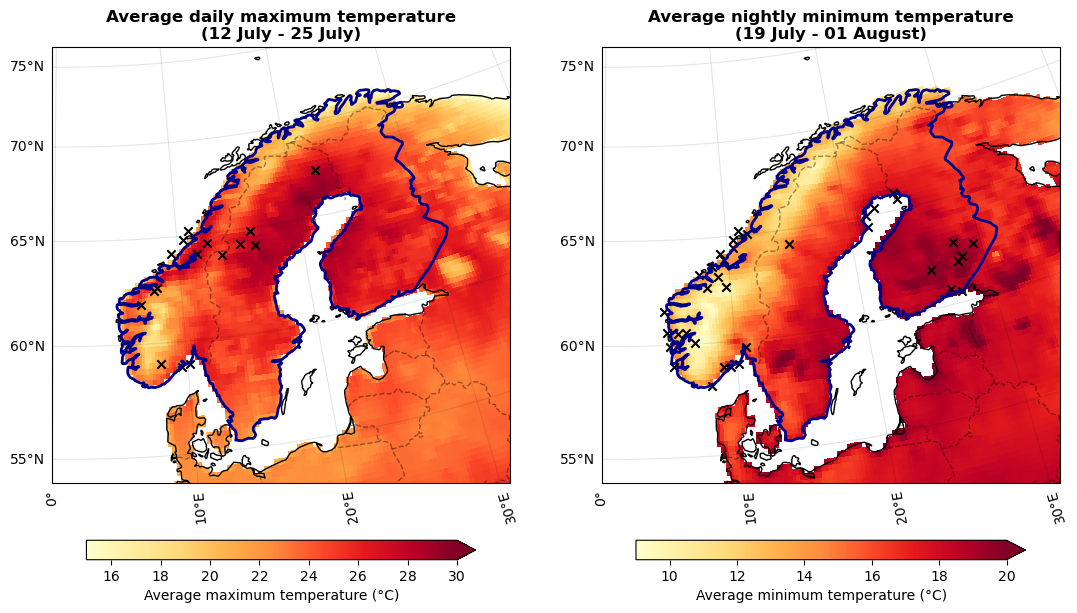

In [28]:
Xn,Xx,Yn,Yx = [0,31.9,54,73]

fig, axs = plt.subplots(ncols = 2, subplot_kw = {"projection" : mapproj, "extent" : (Xn,Xx,Yn,Yx)}, figsize = (13,7.5), dpi = 100)
plt.subplots_adjust(hspace = 0.01)

for i in range(2):
    ax = axs[i]
    ds = [tx14x, tn14x][i]
    
    da = ds.hw_2025
    date_range = ds.date_range

    px = sites.loc[sites.rtype == ["max", "min"][i]]
    
    vrange = [{"vmin" : 15, "vmax" : 30}, {"vmin" : 9, "vmax" : 20}][i]
    
    cbar = ax.pcolormesh(x,y, da, cmap = "YlOrRd", **vrange)
    px.plot(ax = ax, marker = "x", color = "k")
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.4, ls = "--")
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])
    plt.colorbar(cbar, ax = ax, location = "bottom", shrink = 0.85, pad = 0.1, fraction = 0.1, label = "Average "+["max", "min"][i]+"imum temperature (°C)", extend = "max")
    ax.set_title(titles[i]+" temperature\n("+date_range+")", fontweight = "bold")
    sf.to_crs(mapproj).boundary.plot(ax = ax, color = "darkblue", lw = 2)

plt.savefig("fig/event-map.png")

## Daily anomalies

In [69]:
varnm = "tmax"

In [70]:
da = wrap_lon(xr.open_dataset(fpath+"era5_"+varnm+"_daily_land_0-40E_50-75N.nc")[varnm])

da_2025 = da.sel(time = slice("2025-07", None))
da_clim = da.groupby("time.month")[7].sel(time = slice("1990","2020")).mean("time")
da_anom = da_2025 - da_clim
# days = da_anom.sel(time = slice("2025-07-09", "2025-08-05"))
days = da_anom.sel(time = slice("2025-07-07", "2025-08-03"))

In [71]:
x,y = project_latlon(da_clim, to_crs = mapproj)

In [72]:
ts = pd.read_csv("data/t"+varnm[-1]+"-fs-daily_era5.csv", index_col = "time", parse_dates = ["time"]).to_xarray()[varnm].sel(time = "2025")
end_date = ts.rolling(time = 14).mean().idxmax()
start_date = end_date.dt.date - timedelta(days = 13)

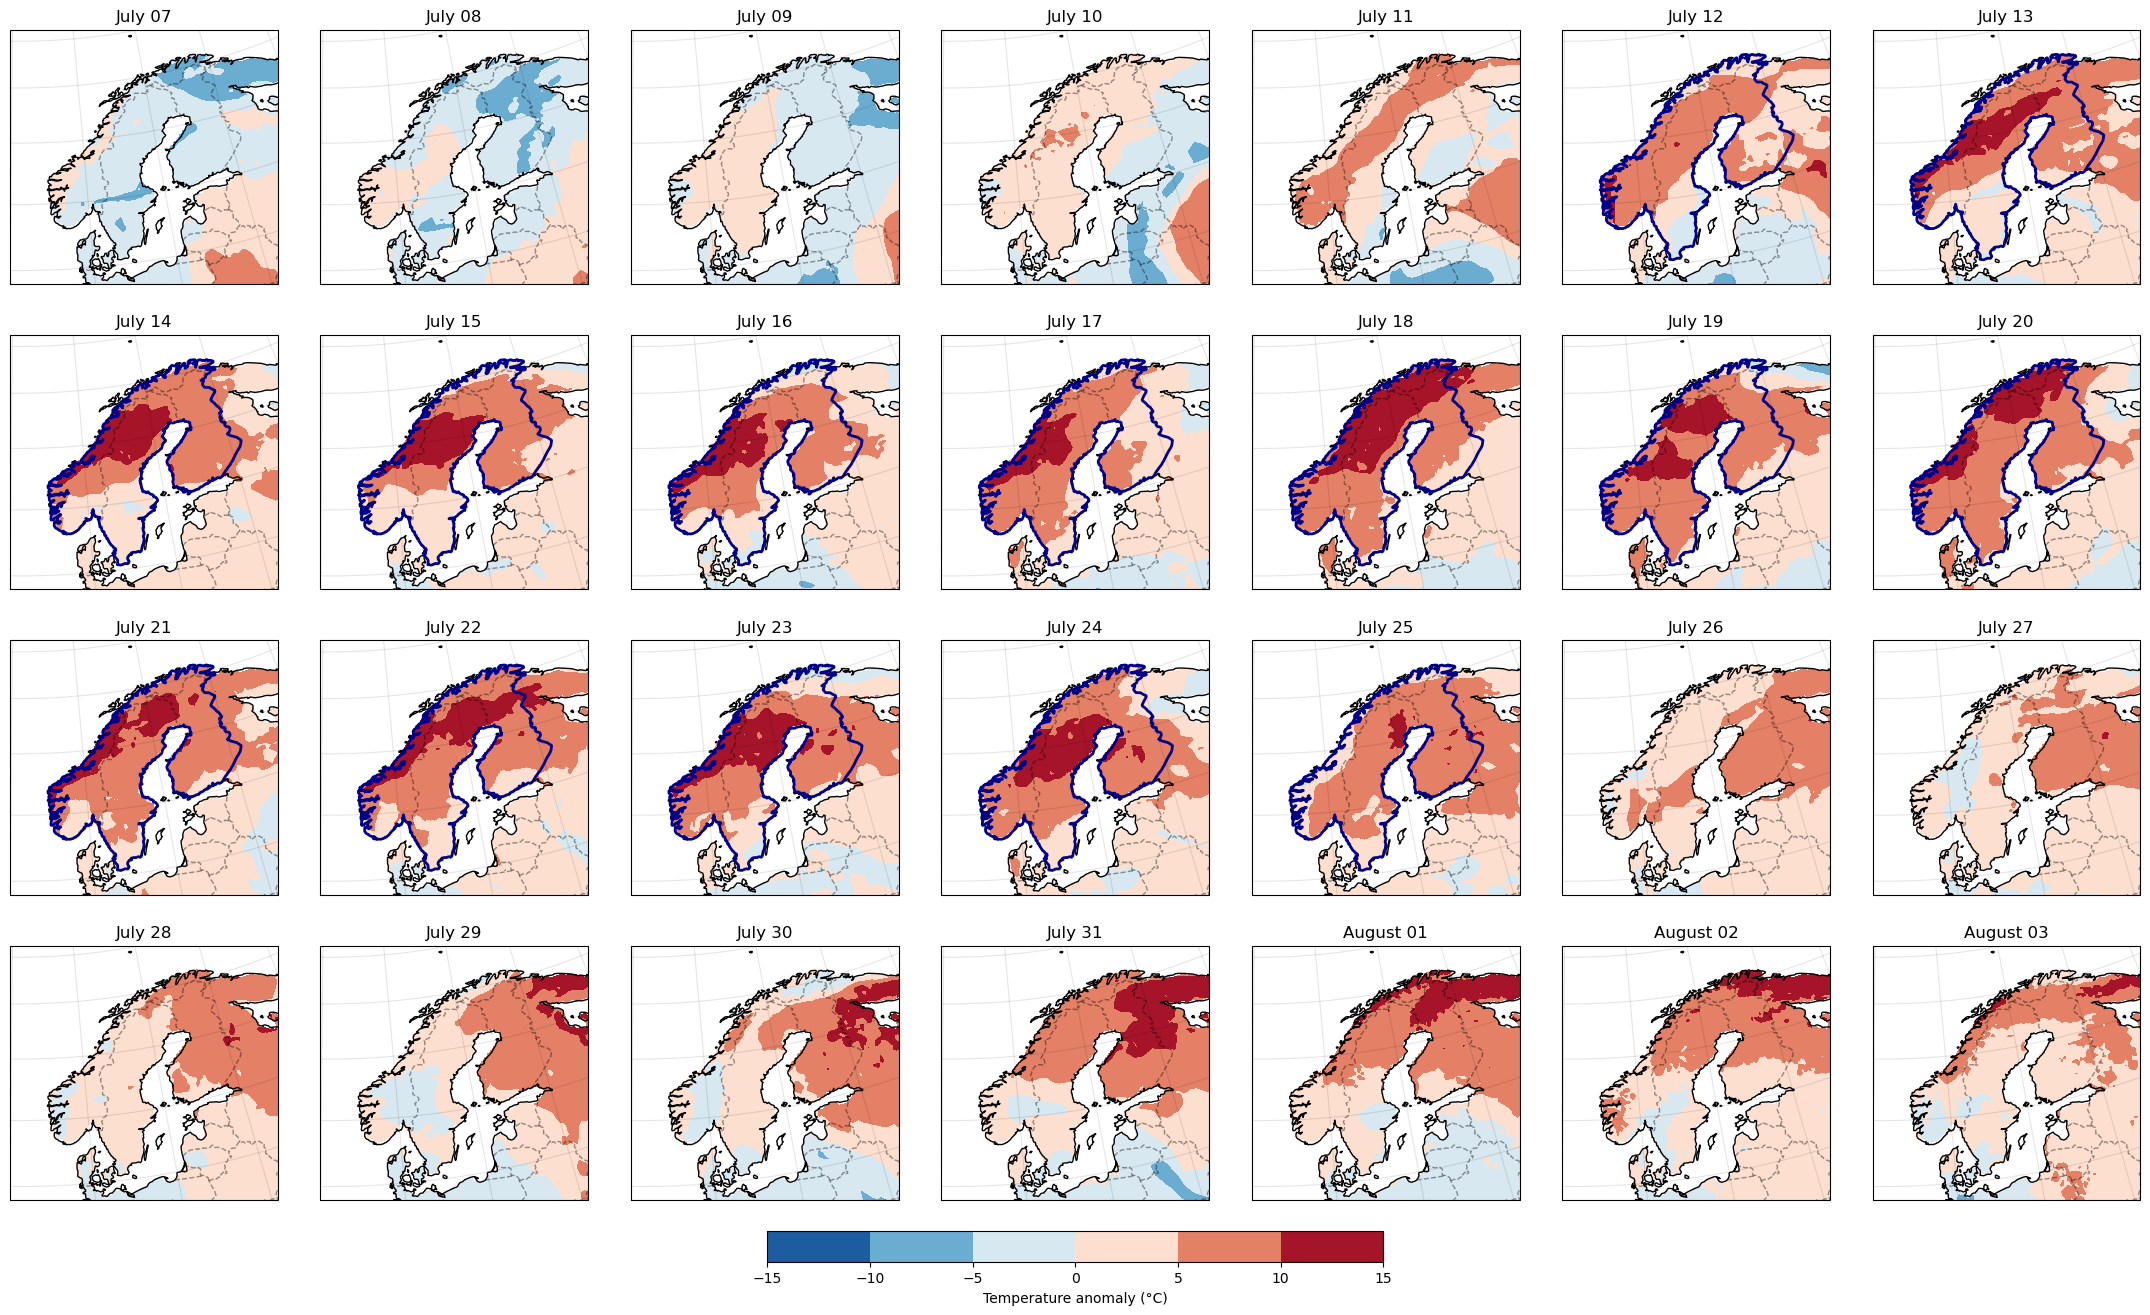

In [73]:
intvl = 5
nc = 7; nr = int(np.ceil(len(days)/nc))

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 4, nr * 4), dpi = 100, subplot_kw = {"projection" : mapproj, "extent" : (Xn,Xx,Yn,Yx)})
plt.subplots_adjust(wspace = 0.01)

max_t = 15 #int(np.ceil(max(np.abs(days.min()), days.max()) / intvl) * intvl)
    
for i in range(len(days)):
    ax = axs.flatten()[i]
    da = days.isel(time = i)
    
    cbar = ax.contourf(x, y, da, levels = range(-max_t,max_t + intvl,intvl), cmap = "RdBu_r")
    ax.coastlines()
    ax.set_title(da.time.dt.strftime("%B %d").values)
    ax.gridlines(color = "k", alpha = 0.1)
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.4, ls = "--")
    
    if da.time.dt.date >= start_date and da.time.dt.date <= end_date.dt.date:
        sf.to_crs(mapproj).boundary.plot(ax = ax, color = "darkblue", lw = 2)
    
# for ax in axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])
# for ax in axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])

for i in range(len(days), nc*nr): axs.flatten()[i].set_axis_off()
    
clb = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.025, pad = 0.025)
clb.ax.tick_params(labelsize = 10) 
clb.set_label(label = "Temperature anomaly (°C)", fontsize = 10)

plt.savefig("fig/daily-anomalies_"+varnm+"_era5")

# Seasonal cycle / accumulations

In [ ]:
for varnm in ["tmax", "tmin"]:

    ts = pd.read_csv("data/t"+varnm[-1]+"-fs-daily_era5.csv", index_col = "time", parse_dates = ["time"]).to_xarray()[varnm]
    end_date = ts.rolling(time = 14).mean().idxmax()
    start_date = end_date.dt.date - timedelta(days = 13)

    ndays = [1,7,14,21,31]

    nc = len(ndays); nr = 1
    fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4, nr*3), dpi = 100, sharex = True, sharey = True)
    plt.subplots_adjust(hspace = 0.35)

    days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
    labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
    labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

    for i in range(nc):
        ax = axs[i]
        nd = ndays[i]

        ts_nday = ts.rolling(time = nd).mean()

        y = 2025; ts_y = ts_nday.sel(time = ts.time.dt.year == y); ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99)
        y = 2018; ts_y = ts_nday.sel(time = ts.time.dt.year == y); ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", alpha = 0.6, label = "2018", zorder = 99)

        for y in range(1990,2020):
            ts_y = ts_nday.sel(time = ts.time.dt.year == y)
            ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.5, label = "_years")

        ax.set_title(str(nd)+"-day mean")

        ax.legend(["2025", "2018", "1990-2020"])
        ax.set_xticks(labelticks)
        ax.set_xticklabels(labels)
        [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
        
#         ylim = ax.get_ylim()
#         ax.add_patch(Rectangle((end_date.dt.dayofyear.values, ylim[0]-5), -14, ylim[1]-ylim[0]+10, color = "gold", alpha = 0.3))
#         ax.set_ylim(ylim)
        
    axs[0].set_ylabel("Daily "+varnm[1:]+"imum temperature (°C)")
    plt.suptitle({"tmax" : "(a)", "tmin" : "(b)"}[varnm]+" Rolling averages of daily "+varnm[1:]+"imum temperatures", x = 0.1, y = 1.02, fontweight = "bold", ha = "left")
    
    plt.savefig("fig/nday-average_"+varnm+"_era5")

# Bar chart showing change in intensity

In [ ]:
varnm = "tx14x" 

era5 = pd.read_csv("ts/fs-heatwave_"+varnm+"_era5.dat", sep = " ", comment = "#", header = None, names = ["year", varnm], index_col = "year")
synth_attr = pd.read_csv("synthesis/synth_dI-attr_"+varnm+"_cmip6+cordex_era-eobs.csv", index_col = "model")
synth_proj = pd.read_csv("synthesis/synth_dI-proj_"+varnm+"_cmip6+cordex.csv", index_col = "model")
gmst = pd.read_table("ts/gmst.txt", comment = "#", sep = " +", engine = "python", header = None, names = ["year", "gmst"], index_col = "year")

In [88]:
t_now = era5.loc[2025,varnm]
dI_hist = synth_attr.loc["Synthesis","est"]
dI_fut = synth_proj.loc["Models","est"]

In [101]:
alpha_hist = dI_hist / 1.3
dI_2018 = (gmst.loc[2025,"gmst"] - gmst.loc[2018,"gmst"]) * alpha_hist
dI_2000 = (gmst.loc[2025,"gmst"] - gmst.loc[2000,"gmst"]) * alpha_hist

In [118]:
temps = pd.DataFrame({"preindustrial" : t_now - dI_hist,
                      # "2000" : t_now - dI_2000,
                      # "2018" : t_now - dI_2018,
                      "2025" : t_now,
                      "future" : t_now + dI_fut}, index = [0])

In [120]:
temps.round(2)

,preindustrial,2025,future
0,22.9,24.87,26.35


<BarContainer object of 5 artists>

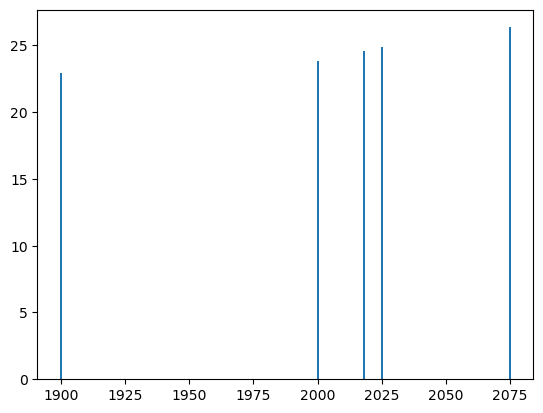

In [115]:
plt.bar(x = [1900,2000,2018,2025,2075], height = temps.iloc[0,:].values)

<AxesSubplot: xlabel='year'>

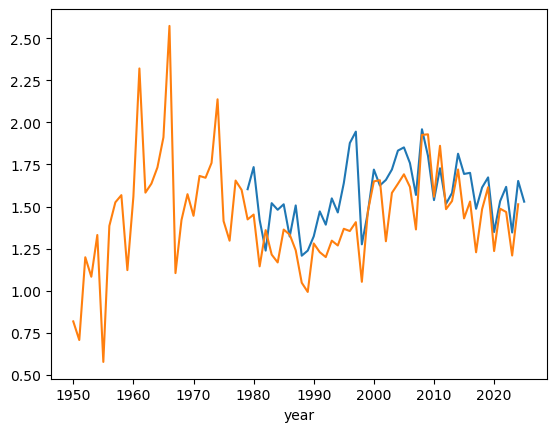

In [64]:
# difference between EOBS/ERA5 and CPC/ERA5 is about 1.5C so this is probably an underestimate of the true mean temperatures

df = merge_byindex([pd.read_csv("ts/fs-heatwave_"+varnm+"_"+ds_nm+".dat", sep = " ", comment = "#", header = None, names = ["year", ds_nm], index_col = "year") 
                    for ds_nm in ["era5", "eobs", "cpc"]])

(df.cpc - df.era5).plot()
(df.eobs - df.era5).plot(ax = plt.gca())


# Synthesis plots

In [98]:
def synth_plot(df, ax = None, logged = False, split_uw = False):
    
    # set split_uw = True to plot the unweighted mean of obs and models on its own line
    if not ax: fig, ax = plt.subplots(dpi = 100)
    
    gcols = {"obs" : "blue", 
             "obs_synth" : "blue", 
             "models" : "red", 
             "model_synth" : "red",
             "synth" : "magenta",
             "synth_uw" : "lightgrey"}
    
    ylabels = df.model.to_list()
    
    ax.grid(axis = "x", which = "major", color = "k", alpha = 0.1)
    
    if logged:
        ax.set_xscale('log')
        ax.axvline(1, ls = "--", color = "k", zorder = -99)
    else:
        ax.axvline(0, ls = "--", color = "k", zorder = -99)
    
    for k in range(len(df)):

        r = df.iloc[k]
        ax.add_patch(Rectangle((r.lower,-k-0.4), r.upper - r.lower, 0.8, facecolor = gcols[r.name], alpha = 0.5 + 0.5*("synth" in r.name)))
        ax.plot(r.est, -k, color = "k", marker = "v")
        ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.8, edgecolor = "k", facecolor = "none", lw = 1.5))

    ax.set_yticks(range(0, -len(ylabels), -1))
    ax.set_yticklabels(ylabels)

In [ ]:
varnm = "tn14x"
models = "cmip6+cordex"
obs = "_era-eobs"

In [ ]:
gcols = {"obs" : "blue", 
             "obs_synth" : "blue", 
             "models" : "red", 
             "model_synth" : "red",
             "synth" : "magenta",
             "synth_uw" : "lightgrey"}

In [ ]:
synth_attr_dI = pd.read_csv("synthesis/synth_dI-attr_"+varnm+"_"+models+obs+".csv", index_col = "group")
synth_attr_PR = pd.read_csv("synthesis/synth_PR-attr_"+varnm+"_"+models+obs+".csv", index_col = "group")

fig, axs = plt.subplots(ncols = 2, sharey = True, figsize = (10,len(synth_attr_dI)*0.25))
plt.subplots_adjust(hspace = 0.01)

synth_plot(synth_attr_dI, ax = axs[0])
axs[0].set_title("Change in intensity")

synth_plot(synth_attr_PR, ax = axs[1], logged = True)
axs[1].set_title("Probability ratio")
# plt.suptitle("Synthesised changes in "+varnm+" ("+{"attr" : "Past-present", "proj" : "Present-future"}[period]+")")

plt.savefig("fig/synth-plot_attr_"+varnm+"_"+models+obs)

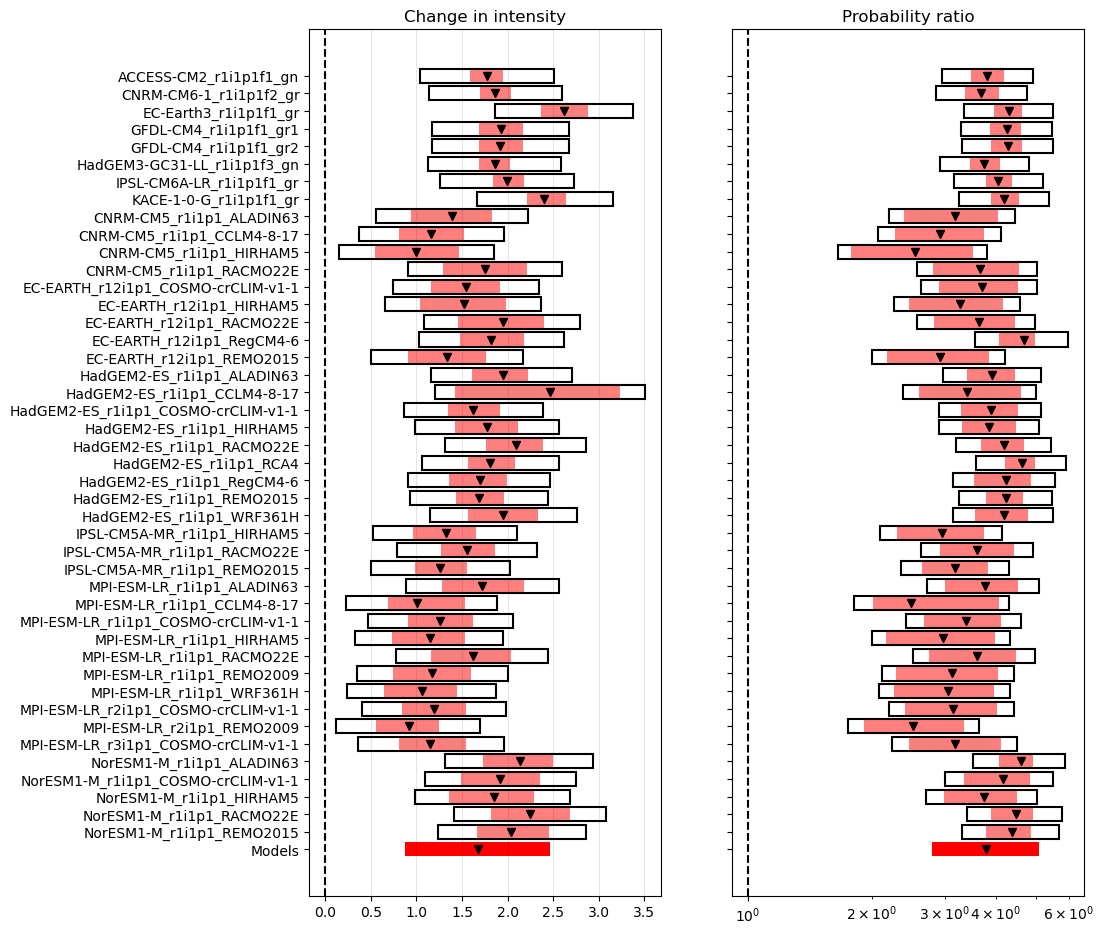

In [54]:
synth_attr_dI = pd.read_csv("synthesis/synth_dI-proj_"+varnm+"_"+models+".csv", index_col = "group")
synth_attr_PR = pd.read_csv("synthesis/synth_PR-proj_"+varnm+"_"+models+".csv", index_col = "group")

xlim_pr = {"tx14x-attr" : (10e-4, 10e20)}

fig, axs = plt.subplots(ncols = 2, sharey = True, figsize = (10,len(synth_attr_dI)*0.25))
plt.subplots_adjust(hspace = 0.1)

synth_plot(synth_attr_dI, ax = axs[0])
axs[0].set_title("Change in intensity")

synth_plot(synth_attr_PR, ax = axs[1], logged = True)
axs[1].set_title("Probability ratio")
# plt.suptitle("Synthesised changes in "+varnm+" ("+{"attr" : "Past-present", "proj" : "Present-future"}[period]+")")

if varnm+"-"+period in xlim_pr.keys():
    axs[1].set_xlim(xlim_pr[varnm+"-"+period])

plt.savefig("fig/synth-plot_proj_"+varnm+"_"+models)